# Introduction

Thanks to [Peter Giannakopoulos](https://www.kaggle.com/petrosgk) and [Heng CherKeng](https://www.kaggle.com/hengck23) for their starter kits. I collected their data augmentation methods and added a few based on the keras.preprocessing.image.

Let me know if they help your learning process.

In [3]:
import numpy as np
from skimage import io
import keras
import pandas as pd
import torch as t
from pathlib import Path
# import tensorflow as tf
from keras.preprocessing import image
from os.path import join
import matplotlib.pyplot as plt
TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
input_size = 256
data_dir = '../input'
np.random.seed(1987)

Using TensorFlow backend.


## Read and show images and masks

In [4]:
def get_image_and_mask(img_id):
    img = image.load_img(join('train/images', '%s_training.tif' % img_id),
                         target_size=(input_size, input_size))
    img = image.img_to_array(img)
    mask = image.load_img(join('train/1st_manual', '%s_manual1.gif' % img_id),
                          grayscale=True, target_size=(input_size, input_size))
    mask = image.img_to_array(mask)
    img, mask = img / 255., mask / 255.
    return img, mask

def plot_img_and_mask(img, mask):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0])
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

((256, 256, 3), (256, 256, 1))


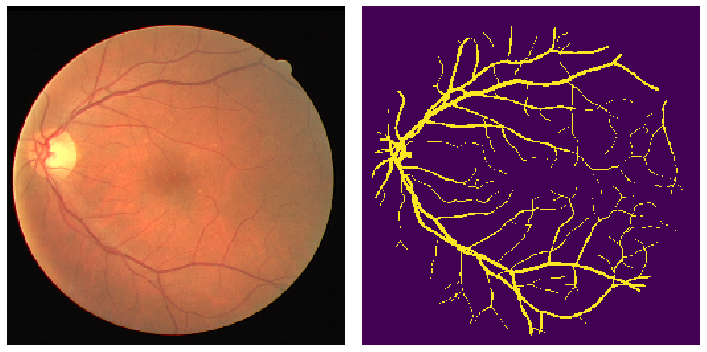

In [5]:
img, mask = get_image_and_mask(21)
print((img.shape, mask.shape))
plot_img_and_mask(img, mask)

# Pixel Transformations

In [6]:
def plot_img_and_mask_transformed(img, mask, img_tr, mask_tr):
    fig, axs = plt.subplots(ncols=4, figsize=(16, 4), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0])
    axs[2].imshow(img_tr)
    axs[3].imshow(mask_tr[:, :, 0])
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

## Flip

In [7]:
def random_flip(img, mask, u=0.5):
    if np.random.random() < u:
        img = image.flip_axis(img, 1)
        mask = image.flip_axis(mask, 1)
    return img, mask

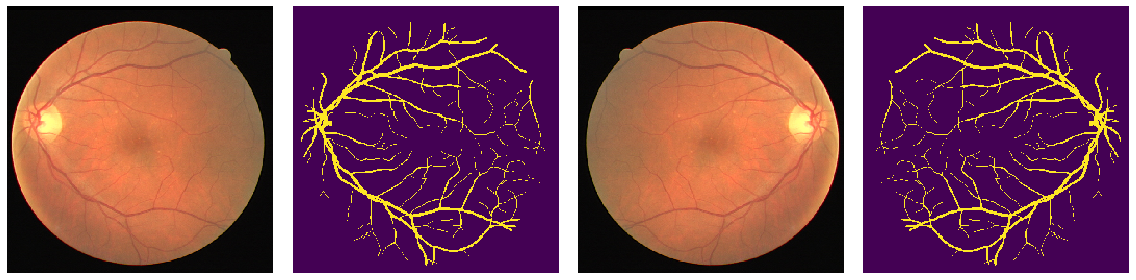

In [8]:
img_flip, mask_flip = random_flip(img, mask, u=1)
plot_img_and_mask_transformed(img, mask, img_flip, mask_flip)

## Rotate

In [9]:
def rotate(x, theta, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(rotation_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        theta = np.pi / 180 * np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = rotate(img, theta)
        mask = rotate(mask, theta)
    return img, mask

theta -0.45


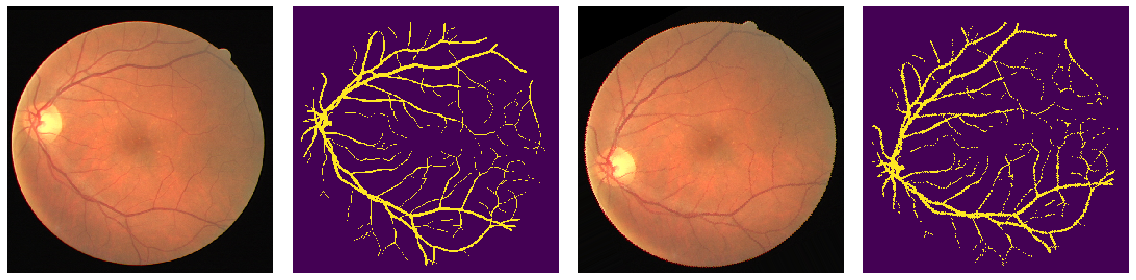

In [10]:
rotate_limit=(-30, 30)
theta = np.pi / 180 * np.random.uniform(rotate_limit[0], rotate_limit[1])
print('theta %.2f' % theta)
img_rot = rotate(img, theta)
mask_rot = rotate(mask, theta)
plot_img_and_mask_transformed(img, mask, img_rot, mask_rot)

## Shift

In [11]:
def shift(x, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hshift * h
    ty = wshift * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    transform_matrix = translation_matrix  # no need to do offset
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        img = shift(img, wshift, hshift)
        mask = shift(mask, wshift, hshift)
    return img, mask

wshift: 0.08, hshift: 0.09


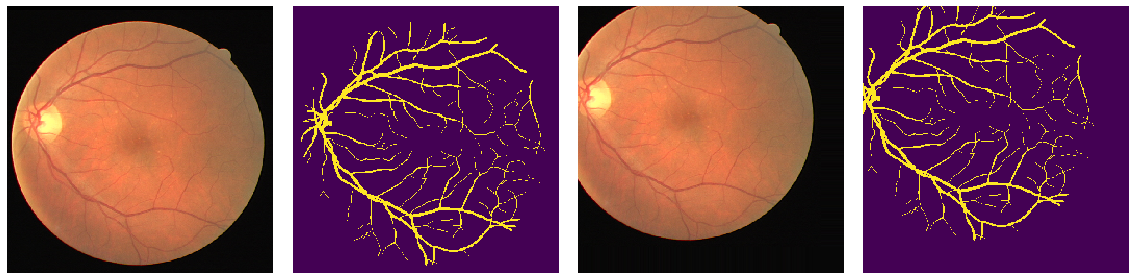

In [12]:
w_limit=(-0.2, 0.2)
h_limit=(-0.2, 0.2)
wshift = np.random.uniform(w_limit[0], w_limit[1])
hshift = np.random.uniform(h_limit[0], h_limit[1])
print('wshift: %.2f, hshift: %.2f' % (wshift, hshift))
img_shift = shift(img, wshift, hshift)
mask_shift = shift(mask, wshift, hshift)
plot_img_and_mask_transformed(img, mask, img_shift, mask_shift)

## Zoom

In [13]:
def zoom(x, zx, zy, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(zoom_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_zoom(img, mask, zoom_range=(0.8, 1), u=0.5):
    if np.random.random() < u:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
        img = zoom(img, zx, zy)
        mask = zoom(mask, zx, zy)
    return img, mask

zx: 0.83, zy: 0.72


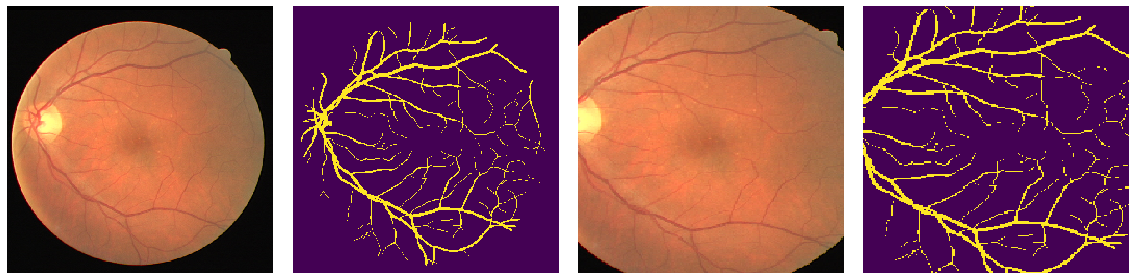

In [14]:
zoom_range=(0.7, 1)
zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
print('zx: %.2f, zy: %.2f' % (zx, zy))
img_zoom = zoom(img, zx, zy)
mask_zoom = zoom(mask, zx, zy)
plot_img_and_mask_transformed(img, mask, img_zoom, mask_zoom)

## Shear

In [15]:
def shear(x, shear, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(shear_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shear(img, mask, intensity_range=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        sh = np.random.uniform(-intensity_range[0], intensity_range[1])
        img = shear(img, sh)
        mask = shear(mask, sh)
    return img, mask

sh: -0.26


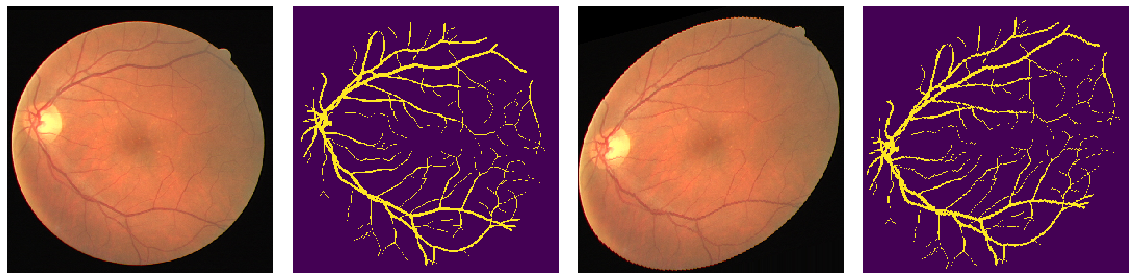

In [16]:
intensity = 0.5
sh = np.random.uniform(-intensity, intensity)
print('sh: %.2f' % sh)
img_shear = shear(img, sh)
mask_shear = shear(mask, sh)
plot_img_and_mask_transformed(img, mask, img_shear, mask_shear)

# Color transformations

In [17]:
def plot_img_transformed(img, img_tr):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(img_tr)
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

## Random channel shift

In [18]:
def random_channel_shift(x, limit, channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_ch + np.random.uniform(-limit, limit), min_x, max_x) for x_ch in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

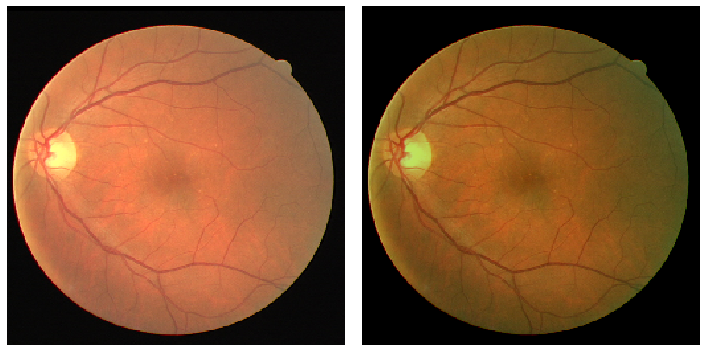

In [33]:
img_chsh = random_channel_shift(img, limit=0.3)
plot_img_transformed(img, img_chsh)

## Grayscale

In [20]:
def random_gray(img, u=0.5):
    if np.random.random() < u:
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = np.sum(img * coef, axis=2)
        img = np.dstack((gray, gray, gray))
    return img

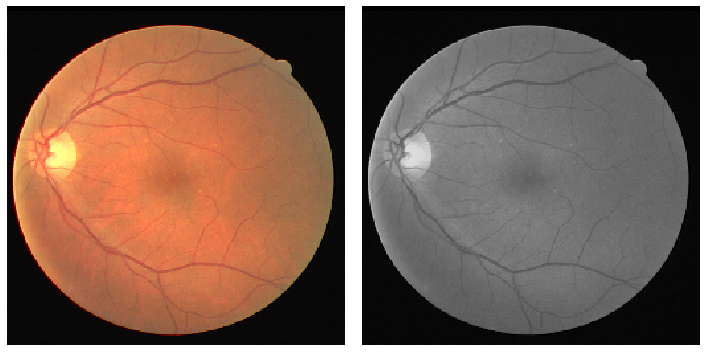

In [21]:
img_gray = random_gray(img, u=1)
plot_img_transformed(img, img_gray)

## Contrast

In [22]:
def random_contrast(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = img * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        img = alpha * img + gray
        img = np.clip(img, 0., 1.)
    return img

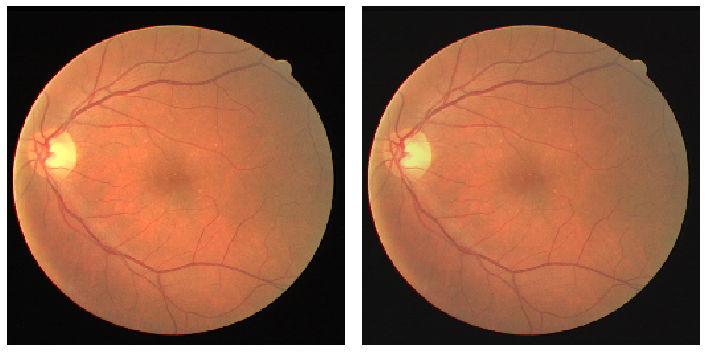

In [23]:
img_contrast = random_contrast(img, u=1)
plot_img_transformed(img, img_contrast)

## Brightness

In [24]:
def random_brightness(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        img = alpha * img
        img = np.clip(img, 0., 1.)
    return img

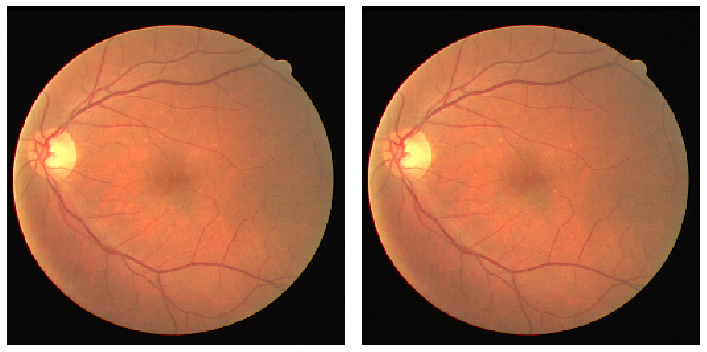

In [25]:
img_brightness = random_brightness(img, u=1)
plot_img_transformed(img, img_brightness)

## Saturation

In [26]:
def random_saturation(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = img * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        img = alpha * img + (1. - alpha) * gray
        img = np.clip(img, 0., 1.)
    return img

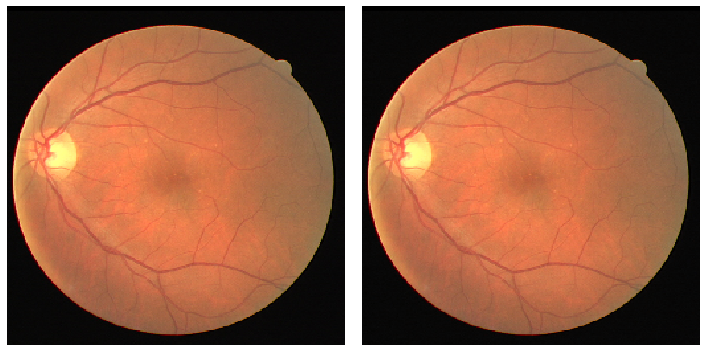

In [27]:
img_sat = random_saturation(img, u=1)
plot_img_transformed(img, img_sat)

# All together
Not all the transformations help the learning process. The limits here were chosen to have visible effects.

I am using less transformations and lower limits in my pipeline.

In [28]:
def plot_img_and_mask_transformed3(img, mask, img_tr1, mask_tr1, img_tr2, mask_tr2):
    fig, axs = plt.subplots(ncols=6, figsize=(30, 5), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0])
    axs[2].imshow(img_tr1)
    axs[3].imshow(mask_tr1[:, :, 0])
    axs[4].imshow(img_tr2)
    axs[5].imshow(mask_tr2[:, :, 0])
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

In [29]:
def random_augmentation(img, mask):
    img = random_channel_shift(img, limit=0.05)
    img = random_brightness(img, limit=(-0.5, 0.5), u=0.5)
    img = random_contrast(img, limit=(-0.5, 0.5), u=0.5)
    img = random_saturation(img, limit=(-0.5, 0.5), u=0.5)
    img = random_gray(img, u=0.2)
    img, mask = random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5)
    img, mask = random_shear(img, mask, intensity_range=(-0.3, 0.3), u=0.2)
    img, mask = random_flip(img, mask, u=0.3)
    img, mask = random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.3)
    img, mask = random_zoom(img, mask, zoom_range=(0.8, 1), u=0.3)
    return img, mask

In [40]:
import scipy
import imageio

In [44]:
for img_id in range(21,241):
    img, mask = get_image_and_mask(img_id)
    img_flip, mask_flip = random_flip(img, mask, u=1)
    img_rotate, mask_rotate = random_rotate(img, mask, rotate_limit=(-20, 20), u=1)
    img_shear, mask_shear = random_shear(img, mask, intensity_range=(-0.3, 0.3), u=1)
    img_shift, mask_shift = random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=1)
    img_zoom, mask_zoom = random_zoom(img, mask, zoom_range=(0.8, 1), u=1)
    img_channel = random_channel_shift(img, limit=0.3)
    img_br = random_brightness(img, limit=(-0.5, 0.5), u=1)
    img_contrast = random_contrast(img, limit=(-0.5, 0.5), u=1)
    img_sat = random_saturation(img, limit=(-0.5, 0.5), u=1)
    img_gray = random_gray(img, u=1)
    imageio.imwrite("train/images/%s_training.tif" % (241+(img_id-21)*10), img_flip)
    imageio.imwrite("train/1st_manual/%s_manual1.gif" % (241+(img_id-21)*10), img_flip)
    imageio.imwrite("train/images/%s_training.tif" % (242+(img_id-21)*10), img_rotate)
    imageio.imwrite("train/1st_manual/%s_manual1.gif" % (242+(img_id-21)*10), mask_rotate)
    imageio.imwrite("train/images/%s_training.tif" % (243+(img_id-21)*10), img_shear)
    imageio.imwrite("train/1st_manual/%s_manual1.gif" % (243+(img_id-21)*10), mask_shear)
    imageio.imwrite("train/images/%s_training.tif" % (244+(img_id-21)*10), img_shift)
    imageio.imwrite("train/1st_manual/%s_manual1.gif" % (244+(img_id-21)*10), mask_shift)
    imageio.imwrite("train/images/%s_training.tif" % (245+(img_id-21)*10), img_zoom)
    imageio.imwrite("train/1st_manual/%s_manual1.gif" % (245+(img_id-21)*10), mask_zoom)
    imageio.imwrite("train/images/%s_training.tif" % (246+(img_id-21)*10), img_sat)
    imageio.imwrite("train/1st_manual/%s_manual1.gif" % (246+(img_id-21)*10), mask)
    imageio.imwrite("train/images/%s_training.tif" % (247+(img_id-21)*10), img_channel)
    imageio.imwrite("train/1st_manual/%s_manual1.gif" % (247+(img_id-21)*10), mask)
    imageio.imwrite("train/images/%s_training.tif" % (248+(img_id-21)*10), img_br)
    imageio.imwrite("train/1st_manual/%s_manual1.gif" % (248+(img_id-21)*10), mask)
    imageio.imwrite("train/images/%s_training.tif" % (249+(img_id-21)*10), img_contrast)
    imageio.imwrite("train/1st_manual/%s_manual1.gif" % (249+(img_id-21)*10), mask)
    imageio.imwrite("train/images/%s_training.tif" % (250+(img_id-21)*10), img_gray)
    imageio.imwrite("train/1st_manual/%s_manual1.gif" % (250+(img_id-21)*10), mask)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

OSError: cannot identify image file 'train/images\\41_training.tif'